[*Link Colab*](https://colab.research.google.com/drive/1oOXYhbgrQaQNllWvsWpeHlVg5y2A0gp-)

#Import image files

Thay vì dùng phương pháp processing từ đầu. sử dụng files đã được xử lý sẵn từ trước

In [5]:
import os
import urllib.request
import zipfile
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd /
if os.path.exists('/content/data'): shutil.rmtree('/content/data')
a=zipfile.ZipFile('/gdrive/My Drive/KLTN/NSL-KDD2.zip')
#extracted folder: /content/NSL-KDD/data
a.extractall()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive
/


# Training

In [0]:
%matplotlib inline

In [0]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/NSL-KDD/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


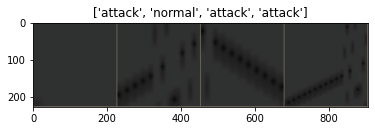

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.2884 Acc: 0.8691
val Loss: 1.3040 Acc: 0.7456

Epoch 1/24
----------
train Loss: 0.1846 Acc: 0.9193
val Loss: 1.0120 Acc: 0.7756

Epoch 2/24
----------
train Loss: 0.1672 Acc: 0.9254
val Loss: 0.8577 Acc: 0.7626

Epoch 3/24
----------
train Loss: 0.1536 Acc: 0.9315
val Loss: 1.4523 Acc: 0.7656

Epoch 4/24
----------
train Loss: 0.1474 Acc: 0.9338
val Loss: 1.3317 Acc: 0.7496

Epoch 5/24
----------


In [0]:
visualize_model(model_ft)

Other model train

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [0]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [0]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Link colab: https://colab.research.google.com/drive/1HqCa56QbGXLdZ9tfhMzJ7rtn_IPNDiDi

#Convert csv to png
Processing từ file txt gốc, chuyển sang các thư mục tương ứng


*   train/normal
*   train/attack
*   val/normal
*   val/attack

import image files rồi thì ko cần chạy cái này








In [0]:
from __future__ import print_function
import sys
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K
import matplotlib
import os
!pip install text_to_image
import text_to_image
import cv2
from google.colab.patches import cv2_imshow
import PIL
import shutil
import time


In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

In [0]:
def unique_size(path):
  files = []
# r=root, d=directories, f = files
  for r, d, f in os.walk(path):
    for file in f:
      if '.png' in file:
        files.append(os.path.join(r, file))
  sizelist=[]
  for f in files:
  #print(f)
    image = PIL.Image.open(f)
    sizelist.append(image.size)
  myset=set(sizelist)
  return myset

In [0]:
def convert_to_rbg(path):
  files = []
# r=root, d=directories, f = files
  for r, d, f in os.walk(path):
    for file in f:
      if '.png' in file:
        files.append(os.path.join(r, file))
  sizelist=[]
  for f in files:
  #print(f)
    image = PIL.Image.open(f)
    image=cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
  myset=set(sizelist)
  return myset

In [0]:
def convert_to_image(file_path,Train_or_Test,root='/content/data/',a=31,b=15):
  k="'{:0"+str(a)+'b'+"}'"
  l="'{:0"+str(b)+'b'+"}'"
  X=pd.read_csv(file_path)
  X.columns=['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'lnum_compromised', 'lroot_shell',
       'lsu_attempted', 'lnum_root', 'lnum_file_creations', 'lnum_shells',
       'lnum_access_files', 'lnum_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label', 'numbers']
  Y=X[['label','numbers']]
  X=X.drop(labels=['label','numbers'],axis=1)
  for i in X.columns:
    if (X[i].dtype=='object'):
      X[i]=X[i].astype('category').cat.codes
  for i in X.columns[X.isna().any()].tolist():
    X[i].fillna(0, inplace = True)
  for i in X.columns:
    if (X[i].dtype!='float64'):
      X[i]=X[i].astype("Int64")
      X[i]=X[i].apply(lambda x: k.format(x))
    if (X[i].dtype=='float64'):
      min=X[i].min()
      max=X[i].max()
      mau=max-min
      X[i]=X[i].apply(lambda x: (x-min)/mau)
      X[i]=X[i].round(1)
      X[i]=X[i].apply(lambda x: x*10)
      X[i]=X[i].astype("Int64")
      X[i]=X[i].apply(lambda x: l.format(pow(2,x)))
  X[['label','numbers']]=Y
  os.mkdir(root+Train_or_Test)
  
  # for i in Y['label'].unique():
  #   a=str(i)
  #   os.mkdir(root+Train_or_Test+'/'+a)
#chi chia 2 loai: attack va normal
  os.mkdir(root+Train_or_Test+'/normal')
  os.mkdir(root+Train_or_Test+'/attack')
  for index, row in X.iterrows():
    if row.values[41]=='normal':
      text_to_image.encode(str(row.values[0:40]), root+Train_or_Test+'/normal/'+str(index) +'.png')
    else:
      text_to_image.encode(str(row.values[0:40]), root+Train_or_Test+'/'+'attack'+'/'+str(index) +'.png')
    print(str(index))

  return unique_size(root+Train_or_Test)

In [0]:
#@title
# if os.path.exists('/content/data'): shutil.rmtree('/content/data')
# start_time = time.time()
# lstt=[]
# for a in range(30,40):
#   for b in range(15,25):
#     os.mkdir('/content/data')
#     size=convert_to_image(KDDTrain,'Train','/content/data/',a,b)
#     lstt.append('a:'+str(a)+' b:'+str(b)+repr(size))
#     if os.path.exists('/content/data'): shutil.rmtree('/content/data')
# print("--- %s seconds ---" % (time.time() - start_time))

In [0]:
KDDTrain='/gdrive/My Drive/KLTN/NSL-KDD old/KDDTrain+.txt'
KDDTest='/gdrive/My Drive/KLTN/NSL-KDD old/KDDTest+.txt'

In [0]:
if os.path.exists('/content/data'): shutil.rmtree('/content/data')
start_time = time.time()
lstt=[]
os.mkdir('/content/data')
a=30
b=21
size=convert_to_image(KDDTrain,'train','/content/data/',a,b)
print("--- %s seconds ---" % (time.time() - start_time))

In [0]:
start_time = time.time()
a=30
b=21
size=convert_to_image(KDDTest,'val','/content/data/',a,b)
print("--- %s seconds ---" % (time.time() - start_time))

In [0]:
# print image size
print('Image size of Train data images: '+ repr(unique_size('/content/data/train')))
print('Image size of Test data images: '+repr(unique_size('/content/data/val')))

#TEST

In [0]:
#@title
# from PIL import Image, ImageDraw
# def is_grey_scale(img_path):
#     img = Image.open(img_path).convert('RGB')
#     w,h = img.size
#     for i in range(w):
#         for j in range(h):
#             r,g,b = img.getpixel((i,j))
#             if r != g != b: return False
#     return True

# def convert_to_rbg(path):
#   files = []
# # r=root, d=directories, f = files
#   for r, d, f in os.walk(path):
#     for file in f:
#       if '.png' in file:
#         files.append(os.path.join(r, file))
#   sizelist=[]
#   for f in files:
#     # print(f)
#     print(is_grey_scale(f))
#     src = cv2.imread(f)
#     image=cv2.cvtColor(src,cv2.COLOR_GRAY2RGB)
#     cv2.imwrite(f, image)

#   myset=set(sizelist)
#   return myset

# convert_to_rbg('/content/data/train')

In [0]:
# from PIL import Image, ImageDraw
# def is_grey_scale(img_path):
#     img = Image.open(img_path).convert('RGB')
#     w,h = img.size
#     for i in range(w):
#         for j in range(h):
#             r,g,b = img.getpixel((i,j))
#             if r != g != b: return False
#     return True

# def convert_to_rbg(path):
#   files = []
# # r=root, d=directories, f = files
#   for r, d, f in os.walk(path):
#     for file in f:
#       if '.png' in file:
#         files.append(os.path.join(r, file))
#   sizelist=[]
#   for f in files:
#     # print(f)
#     print(is_grey_scale(f))
#     src = cv2.imread(f)
#     image=cv2.cvtColor(src,cv2.COLOR_BGR2RGB)
#     cv2.imwrite(f, image)

#   myset=set(sizelist)
#   return myset

# convert_to_rbg('/content/data/train')

zip folder and save in google drive


In [0]:
cd /gdrive/My Drive/KLTN

In [0]:
from zipfile import ZipFile
# create a ZipFile object
with ZipFile('NSL-KDD.zip', 'w') as zipObj:
# Iterate over all the files in directory
  for folderName, subfolders, filenames in os.walk('/content/data'):
    for filename in filenames:
#create complete filepath of file in directory
      filePath = os.path.join(folderName, filename)
# Add file to zip
      zipObj.write(filePath)

move files png to folder

In [0]:
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk('/content/NSL-KDD/data/train/'):
  for file in f:
    if '.png' in file:
      files.append(os.path.join(r, file))
sizelist=[]


for f in files:
  shutil.move(f,'/content/NSL-KDD/data/train/attack')